# Preliminaries

In [1]:
using StatsPlots
using LinearAlgebra
using Random
using Statistics
using Distributions
using Plots
using LaTeXStrings
using DataFrames
using Dates

In [2]:
function MHRW(energia,np,p0,δ=0.5,iterations=10000)
    
    
    #Muestras del algorimo
    samples = zeros(np,iterations)
    #Punto de partida
    ## Se escoge el punto inicial
    samples[:,1] = p0
    
    #Probabilidades
    probabilities = zeros(iterations)
    probabilities[1] = energia(samples[:,1])
    
    #Tasa de aceptación
    rateAlpha = 0
    
    # Algoritmo Metrópolis-Hastings
    for i in 1:iterations-1
        
        #Estado actual
        Xᵢ = samples[:,i]
        #Estado propuesto
        X₊ = rand(MvNormal(Xᵢ,δ*I))
        
        #π(Estado actual → Estado propuesto)
        pXᵢX₊ = energia(X₊) * pdf(MvNormal(Xᵢ,δ*I),X₊)
        #π(Estado propuesto → Estado actual)
        pX₊Xᵢ = energia(Xᵢ) * pdf(MvNormal(X₊,δ*I),Xᵢ)
        #Tasa de aceptacion α
        if pX₊Xᵢ>0
            alpha = min(1, pXᵢX₊/pX₊Xᵢ)
        else
            alpha = 0.0
        end
    
        #Aceptación o rechazo del estado propuesto
        u = rand()    
        if u < alpha 				#Aceptación
            samples[:,i+1] = X₊
            probabilities[i+1] = energia(X₊)
            rateAlpha += 1
        else 						#Rechazo
            samples[:,i+1] = Xᵢ
            probabilities[i+1] = energia(Xᵢ)
        end
    end
    rateAlpha /= (iterations-1)
    MAP = samples[:,findmax(probabilities)[2]]
    CM = [mean(row) for row in eachrow(samples)]
    return samples, probabilities, MAP, CM, rateAlpha
end

MHRW (generic function with 3 methods)

In [3]:
function MCIntegration(s)
    n = length(s)
    integral = zeros(n)
    convergence = zeros(n-1)
    for i in 1:n
        integral[i] = mean(s[1:i])
    end
    for j in 2:n
        convergence[j-1] = norm(integral[j]-integral[j-1])
    end

    rate = [ones(n-1) log.(1:n-1) ] \ log.(convergence .+ 1E-6)
    
    return convergence, rate
end

MCIntegration (generic function with 1 method)

In [4]:
function bydensity(xhist,yhist,min,max,xl="x",yl="y")
    sxy = plot(StatsPlots.KernelDensity.kde((xhist,yhist)), 
        colorbar=false,color=:RdBu,label="",xlabel=xl, ylabel=yl, border=:box,xlim=(min,max),ylim=(min,max))
    
    # sxy = scatter!(xhist[1:50:end], yhist[1:50:end], markersize=2, title="", color="black", alpha=0.9,
    #     colorbar=false)
    
    hx = histogram(xhist,color=:dodgerblue,xlim=(min,max),yaxis=false,grid=false,bins=50)
    
    hy = histogram(yhist, orientation=:horizontal,ylim=(min,max),color=:lightcoral,xaxis=false,grid=false,bins=50)
    
    p0 = Plots.Plot()
    
    cuadricula = grid(2,2, heights=(0.2,0.8), widths=(0.8,0.2))
    
    Totalplot = plot(hx, p0, sxy, hy, legend=:none, layout=cuadricula,size=(800,600))
    return Totalplot
end

bydensity (generic function with 3 methods)

# Data

In [5]:
fechas_str = [
    "8/3/2023", "8/3/2023", "8/3/2023", "8/3/2023",
    "15/3/2023", "15/3/2023", "15/3/2023", "15/3/2023",
    "22/3/2023", "22/3/2023", "22/3/2023", "22/3/2023",
    "29/3/2023", "29/3/2023", "29/3/2023", "29/3/2023",
    "5/4/2023", "5/4/2023", "5/4/2023", "5/4/2023",
    "12/4/2023", "12/4/2023", "12/4/2023", "12/4/2023",
    "19/4/2023", "19/4/2023", "19/4/2023", "19/4/2023",
    "26/4/2023", "26/4/2023", "26/4/2023", "26/4/2023",
    "3/5/2023", "3/5/2023", "3/5/2023", "3/5/2023",
    "10/5/2023", "10/5/2023", "10/5/2023", "10/5/2023",
    "17/5/2023", "17/5/2023", "17/5/2023", "17/5/2023",
    "24/5/2023", "24/5/2023", "24/5/2023", "24/5/2023",
    "31/5/2023", "31/5/2023", "31/5/2023", "31/5/2023",
    "7/6/2023", "7/6/2023", "7/6/2023", "7/6/2023",
    "15/6/2023", "15/6/2023", "15/6/2023", "15/6/2023",
    "22/6/2023", "22/6/2023", "22/6/2023", "22/6/2023",
    "29/6/2023", "29/6/2023", "29/6/2023", "29/6/2023",
    "6/7/2023", "6/7/2023", "6/7/2023", "6/7/2023",
    "12/7/2023", "12/7/2023", "12/7/2023", "12/7/2023",
    "19/7/2023", "19/7/2023", "19/7/2023", "19/7/2023",
    "25/7/2023", "25/7/2023", "25/7/2023", "25/7/2023",
    "2/8/2023", "2/8/2023", "2/8/2023", "2/8/2023",
    "19/10/2023", "19/10/2023", "25/10/2023", "25/10/2023",
    "1/11/2023", "1/11/2023", "8/11/2023", "8/11/2023",
    "15/11/2023", "15/11/2023", "22/11/2023", "22/11/2023",
    "29/11/2023", "29/11/2023", "6/12/2023", "6/12/2023"
]

fechas = Date.(fechas_str, "d/m/yyyy")

alturas = [
    66, 62, 65, 68, 86, 77, 83, 88, 117, 101, 111, 115,
    147, 134, 144, 135, 165, 157, 162, 153, 182, 167, 181, 175,
    197, 182, 203, 196, 216, 204, 233, 215, 232, 218, 234, 240,
    248, 238, 256, 244, 270, 251, 267, 252, 287, 266, 286, 258,
    302, 290, 302, 269, 322, 297, 325, 282, 336, 304, 339, 294,
    350, 314, 354, 311, 373, 324, 369, 326, 390, 326, 384, 341,
    409, 334, 399, 344, 435, 342, 415, 358, 449, 352, 427, 371,
    473, 361, 445, 389, 16, 10.6, 17, 11, 20, 31, 39, 47, 58, 68,
    83, 92, 113, 107, 132, 125
]

num_hojas = [
    15, 15, 17, 16, 16, 16, 19, 18, 18, 17, 20, 20,
    21, 20, 23, 22, 23, 22, 24, 24, 13, 11, 23, 14,
    15, 14, 17, 17, 18, 11, 17, 15, 21, 15, 17, 16,
    16, 18, 20, 18, 19, 14, 16, 15, 19, 17, 17, 17,
    24, 19, 21, 20, 25, 18, 22, 19, 22, 23, 25, 23,
    26, 26, 28, 25, 28, 19, 27, 25, 30, 20, 31, 25,
    32, 23, 34, 26, 22, 9, 34, 21, 22, 10, 18, 21,
    23, 9, 15, 21, 7, 6, 7, 6, 11, 7, 9, 13, 10, 12,
    11, 12, 16, 15, 16, 16
]

area_foliar_total = [
    2.268, 1.566, 2.5432, 1.6128, 3.168, 2.9184, 3.1008, 3.0528, 1.548, 4.6665, 
    2.496, 2.94, 3.2571, 4.056, 4.5747, 1.848, 3.1349, 3.5156, 3.8016, 2.916, 
    1.872, 1.6368, 2.7048, 2.016, 1.638, 1.5876, 1.5249, 1.632, 1.5732, 1.848, 
    2.0706, 0.945, 2.2533, 1.7835, 1.6575, 1.7712, 1.3056, 1.2654, 1.28, 1.0944, 
    1.6416, 1.6464, 1.6416, 1.2375, 0.7714, 1.53, 1.8819, 0.9486, 1.1832, 
    1.5466, 1.4112, 1.102, 2.73, 1.7982, 2.156, 1.3794, 1.4784, 1.2236, 1.8125, 
    1.9872, 2.366, 0.8112, 3.7632, 1.12, 1.1368, 1.14, 2.0493, 0.0, 2.592, 0.66, 
    2.2816, 1.08, 1.7408, 0.437, 0.9996, 0.7488, 1.1594, 0.3276, 1.972, 1.3167, 
    2.2572, 0.54, 0.6048, 0.84, 2.0424, 0.36, 0.945, 1.6632, 0.04536, 0.015498, 
    0.0378, 0.1008, 0.3388, 0.2205, 0.2835, 0.1183, 1.628, 0.8976, 1.6192, 
    2.4804, 2.2704, 1.89, 1.6192, 1.664
]


racimos = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 
    6, 5, 5, 6, 6, 6, 7, 8, 7, 7, 8, 9, 8, 7, 9, 10, 9, 8, 10, 11, 10, 8, 11, 11, 11, 9, 12, 12, 12, 9, 13, 12, 13, 9, 14, 12, 
    14, 9, 15, 13, 15, 10, 15, 13, 16, 11, 16, 14, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 2, 3
]

Datos = DataFrame(Fechas = fechas, 
    AlturaPlanta = alturas,
    NoHojas = num_hojas,
    AreaFoliar = area_foliar_total,
    NoRacimos = racimos)

Datos = Datos[1:88, :]

Row,Fechas,AlturaPlanta,NoHojas,AreaFoliar,NoRacimos
,Date,Float64,Int64,Float64,Int64
1,2023-03-08,66.0,15,2.268,0
2,2023-03-08,62.0,15,1.566,0
3,2023-03-08,65.0,17,2.5432,0
4,2023-03-08,68.0,16,1.6128,0
5,2023-03-15,86.0,16,3.168,0
6,2023-03-15,77.0,16,2.9184,0
7,2023-03-15,83.0,19,3.1008,0
8,2023-03-15,88.0,18,3.0528,0
9,2023-03-22,117.0,18,1.548,0


In [6]:
Datos[Datos.Fechas .== Date("8/3/2023", "d/m/yyyy"), :]

Row,Fechas,AlturaPlanta,NoHojas,AreaFoliar,NoRacimos
,Date,Float64,Int64,Float64,Int64
1,2023-03-08,66.0,15,2.268,0
2,2023-03-08,62.0,15,1.566,0
3,2023-03-08,65.0,17,2.5432,0
4,2023-03-08,68.0,16,1.6128,0


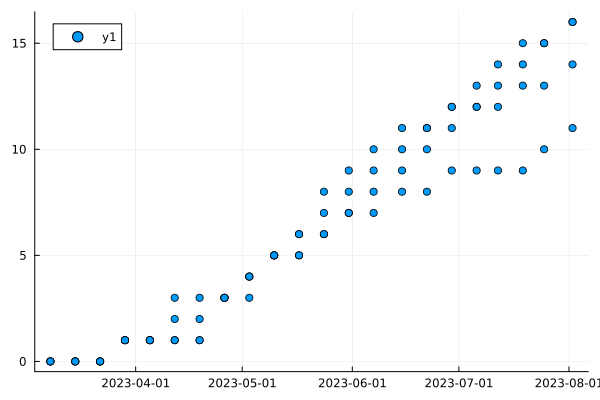

In [7]:
scatter(Datos[!,"Fechas"],Datos[!,"NoRacimos"])

In [8]:
grouped_data = combine(groupby(Datos, :Fechas), 
                       :AlturaPlanta => mean, 
                       :NoHojas => mean, 
                       :AreaFoliar => mean, 
                       :NoRacimos => mean)

grouped_data.Day = [Int((grouped_data.Fechas[i] - grouped_data.Fechas[1]).value) for i in 1:nrow(grouped_data)]


# Mostrar el resultado
println(grouped_data)

22×6 DataFrame
 Row │ Fechas      AlturaPlanta_mean  NoHojas_mean  AreaFoliar_mean  NoRacimos_mean  Day   
     │ Date        Float64            Float64       Float64          Float64         Int64 
─────┼─────────────────────────────────────────────────────────────────────────────────────
   1 │ 2023-03-08              65.25         15.75          1.9975             0.0       0
   2 │ 2023-03-15              83.5          17.25          3.06               0.0       7
   3 │ 2023-03-22             111.0          18.75          2.91262            0.0      14
   4 │ 2023-03-29             140.0          21.5           3.43395            1.0      21
   5 │ 2023-04-05             159.25         23.25          3.34203            1.0      28
   6 │ 2023-04-12             176.25         15.25          2.0574             1.75     35
   7 │ 2023-04-19             194.5          15.75          1.59562            1.75     42
   8 │ 2023-04-26             217.0          15.25          1.6092      

In [9]:
Time = grouped_data[!,"Day"]

22-element Vector{Int64}:
   0
   7
  14
  21
  28
  35
  42
  49
  56
  63
  70
  77
  84
  91
  99
 106
 113
 120
 126
 133
 139
 147

In [10]:
Measurements = Matrix(grouped_data)[:,2:5]

22×4 Matrix{Any}:
  65.25  15.75  1.9975    0.0
  83.5   17.25  3.06      0.0
 111.0   18.75  2.91262   0.0
 140.0   21.5   3.43395   1.0
 159.25  23.25  3.34203   1.0
 176.25  15.25  2.0574    1.75
 194.5   15.75  1.59562   1.75
 217.0   15.25  1.6092    3.0
 231.0   17.25  1.86637   3.75
 246.5   18.0   1.23635   5.0
 260.0   16.0   1.54178   5.5
 274.25  17.5   1.28297   6.75
 290.75  21.0   1.31075   7.75
 306.5   21.0   2.0159    8.5
 318.25  23.25  1.62542   9.5
 332.25  26.25  2.0151   10.0
 348.0   24.75  1.08153  11.0
 360.25  26.5   1.6534   11.5
 371.5   28.75  0.98155  12.0
 387.5   21.5   1.19393  12.75
 399.75  17.75  1.0605   13.25
 417.0   17.0   1.25265  14.25

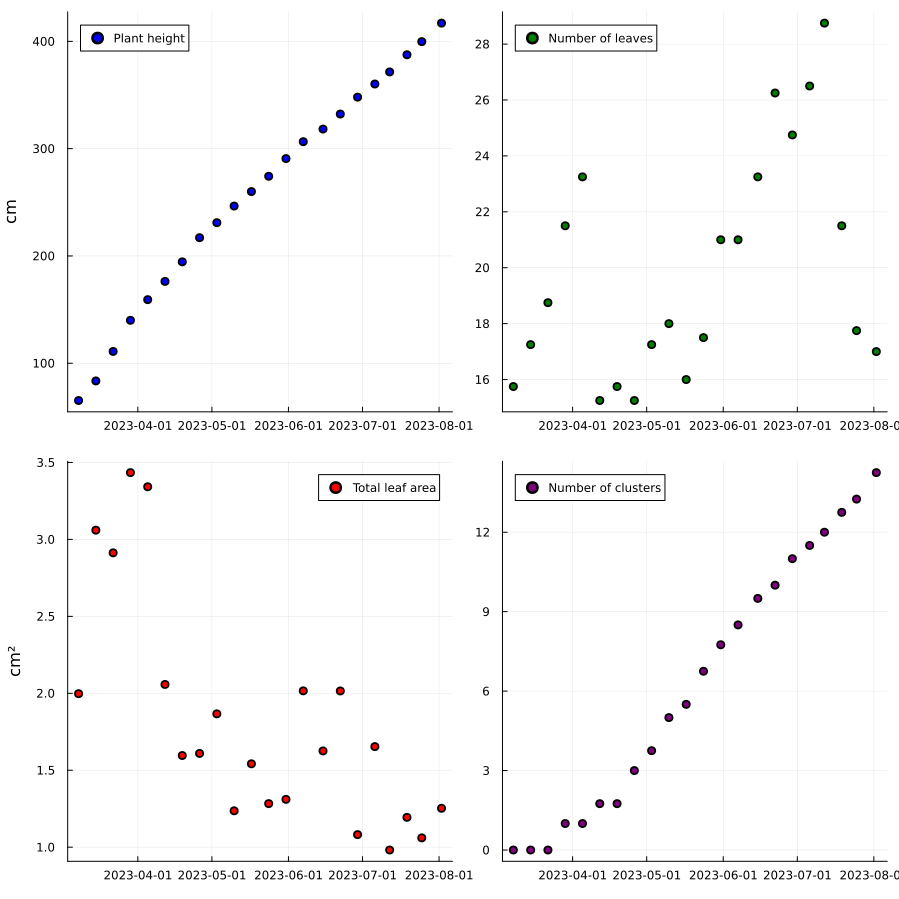

In [11]:
# Crear los subgráficos
p1 = scatter(grouped_data.Fechas, grouped_data.AlturaPlanta_mean, label="Plant height", ylabel="cm", color=:blue)
p2 = scatter(grouped_data.Fechas, grouped_data.NoHojas_mean, label="Number of leaves", color=:green)
p3 = scatter(grouped_data.Fechas, grouped_data.AreaFoliar_mean, label="Total leaf area", ylabel="cm²", color=:red)
p4 = scatter(grouped_data.Fechas, grouped_data.NoRacimos_mean, label="Number of clusters",color=:purple)

# Mostrar los cuatro gráficos en un solo layout
plot(p1, p2, p3, p4, layout=(2, 2), size=(900,900))
#savefig("5_TOMGRODataPlot.png")

# Solve the system

In [12]:
Measurements

22×4 Matrix{Any}:
  65.25  15.75  1.9975    0.0
  83.5   17.25  3.06      0.0
 111.0   18.75  2.91262   0.0
 140.0   21.5   3.43395   1.0
 159.25  23.25  3.34203   1.0
 176.25  15.25  2.0574    1.75
 194.5   15.75  1.59562   1.75
 217.0   15.25  1.6092    3.0
 231.0   17.25  1.86637   3.75
 246.5   18.0   1.23635   5.0
 260.0   16.0   1.54178   5.5
 274.25  17.5   1.28297   6.75
 290.75  21.0   1.31075   7.75
 306.5   21.0   2.0159    8.5
 318.25  23.25  1.62542   9.5
 332.25  26.25  2.0151   10.0
 348.0   24.75  1.08153  11.0
 360.25  26.5   1.6534   11.5
 371.5   28.75  0.98155  12.0
 387.5   21.5   1.19393  12.75
 399.75  17.75  1.0605   13.25
 417.0   17.0   1.25265  14.25

In [13]:
function solve_system(p, t_final=147, dt=0.02, H0=65.25, N_L0=15.75, A_L0=1.9975, N_C0=0.001)
    # Extraer los parámetros del vector p
    h, l, a, c = p
    
    # Inicializar los vectores para las soluciones
    t = 0:dt:t_final
    n = length(t)
    H = zeros(n)
    N_L = zeros(n)
    A_L = zeros(n)
    N_C = zeros(n)
    
    # Condiciones iniciales
    H[1] = H0
    N_L[1] = N_L0
    A_L[1] = A_L0
    N_C[1] = N_C0
    
    # Método de Euler
    for i in 1:n-1
        # Calcular las derivadas
        dH = h 
        dN_L = l 
        dA_L = a 
        dN_C = c 
        
        # Actualizar los valores de las variables
        H[i+1] = H[i] + dH * dt
        N_L[i+1] = N_L[i] + dN_L * dt
        A_L[i+1] = A_L[i] + dA_L * dt
        N_C[i+1] = N_C[i] + dN_C * dt
    end
    
    # Retornar los resultados
    return hcat(H[1:350:end], N_L[1:350:end], A_L[1:350:end], N_C[1:350:end])
end


solve_system (generic function with 7 methods)

In [44]:
solve_system([2.0,0.03,0.0001,0.04])

22×4 Matrix{Float64}:
  65.25  15.75  1.9975  0.001
  79.25  15.96  1.9982  0.281
  93.25  16.17  1.9989  0.561
 107.25  16.38  1.9996  0.841
 121.25  16.59  2.0003  1.121
 135.25  16.8   2.001   1.401
 149.25  17.01  2.0017  1.681
 163.25  17.22  2.0024  1.961
 177.25  17.43  2.0031  2.241
 191.25  17.64  2.0038  2.521
 205.25  17.85  2.0045  2.801
 219.25  18.06  2.0052  3.081
 233.25  18.27  2.0059  3.361
 247.25  18.48  2.0066  3.641
 261.25  18.69  2.0073  3.921
 275.25  18.9   2.008   4.201
 289.25  19.11  2.0087  4.481
 303.25  19.32  2.0094  4.761
 317.25  19.53  2.0101  5.041
 331.25  19.74  2.0108  5.321
 345.25  19.95  2.0115  5.601
 359.25  20.16  2.0122  5.881

# Energy

In [159]:
function energy(p)
    μ = Float64.(vec(solve_system(p)))
    s = Float64.(vec(Measurements))
    γ² = (0.9)^2

    loglikelihood = logpdf(MvNormal(μ,γ²*I),s)
    prior = 1.0
    for k in 1:4
        prior *= 8*pdf(Uniform(-4.0,4.0),p[k])
    end 
    return exp(1E-4*loglikelihood)prior
end

energy([3.2,-0.03,0.0001,0.04])

0.008152307706890776

# MHRW

In [190]:
samples, probabilities, MAP, CM, rateAlpha = MHRW(energy,4,[3.18792  0.20991  0.01497  0.0918293],1E-8,5000)

([3.18792 3.1878222158446627 … 3.175130640978637 3.175039406638794; 0.20991 0.2099526299492427 … 0.21297008655311686 0.21308886711908392; 0.01497 0.014987113694942964 … 0.011355282000219942 0.011380139041944905; 0.0918293 0.09186000377898354 … 0.07946833476539672 0.07954775946843133], [0.008185791638275715, 0.00819497965188139, 0.008179668247188167, 0.008174571849406656, 0.008157307223493207, 0.008161055194980263, 0.008183190819743237, 0.008160745443049998, 0.008177124177638023, 0.00816536912274487  …  0.009600438258654524, 0.009593316389025787, 0.009578733704434648, 0.009589773114312413, 0.009591501862452698, 0.009580272541037377, 0.009554695562045792, 0.009558910183255645, 0.009544122314541529, 0.009551626045213535], [3.174494916063845, 0.2130858148476334, 0.010763301769789067, 0.07947090511522167], [3.180861811902888, 0.2106361871274522, 0.010665258222982088, 0.08712656482487521], 0.9991998399679936)

In [198]:
p1 = density(samples[1,:],label="",xlim=(3.15,3.20),color=:gray, fill=true, alpha=0.2)
p1 = vline!([MAP[1]], color=:red,label="",lw=2,linestyle=:dash)
p1 = vline!([CM[1]], color=:blue,label="",lw=2,linestyle=:dash)

p2 = density(samples[2,:],label="",xlim=(0.15,0.25),color=:gray, fill=true, alpha=0.2)
p2 = vline!([MAP[2]], color=:red,label="",lw=2,linestyle=:dash)
p2 = vline!([CM[2]], color=:blue,label="",lw=2,linestyle=:dash)


p3 = density(samples[3,:],label="",xlim=(0.0,0.04),color=:gray, fill=true, alpha=0.2)
p3 = vline!([MAP[3]], color=:red,label="",lw=2,linestyle=:dash)
p3 = vline!([CM[3]], color=:blue,label="",lw=2,linestyle=:dash)

p4 = density(samples[4,:],label="",xlim=(0.05,0.11),color=:gray, fill=true, alpha=0.2)
p4 = vline!([MAP[4]], color=:red,label="",lw=2,linestyle=:dash)
p4 = vline!([CM[4]], color=:blue,label="",lw=2,linestyle=:dash)

plot(p1,p2,p3,p4,layout=(2,2),size =(600,600))

#savefig("5_TOMGRO_PEinRD_Histograms.png")

"C:\\Users\\carlo\\5_TOMGRO_PEinRD_Histograms.png"

In [183]:
integ = MCIntegration(mean(samples,dims=1))

([7.634169386316891e-6, 5.235977967088523e-6, 1.775241943757777e-5, 8.737660476598741e-6, 7.597153016347669e-6, 7.707290284875157e-6, 7.718064303441352e-6, 1.1147899538932471e-5, 3.494677541460156e-6, 3.6007010452143717e-6  …  8.236436331854335e-7, 8.092708050355668e-7, 8.065636188936409e-7, 8.068944982175807e-7, 8.079688295081766e-7, 7.985778812669153e-7, 7.901538620069815e-7, 7.895726511497614e-7, 7.824340932938156e-7, 7.682205563908084e-7], [-12.648231066953281, -0.08829477212461392])

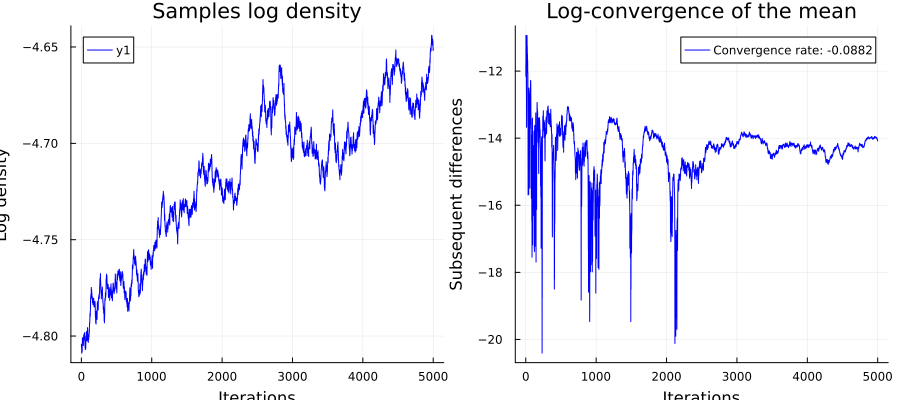

In [202]:
p01 = plot(log.(probabilities),xlabel="Iterations",ylabel="Log density", title="Samples log density",color=:blue)
p02 = plot(log.(integ[1]),label="Convergence rate: -0.0882",title="Log-convergence of the mean",xlabel="Iterations",ylabel="Subsequent differences",
color=:blue)

plot(p01,p02,layout=(1,2),size=(900,400))
#savefig("5_TOMGRO_PEinRD_Convergence.png")

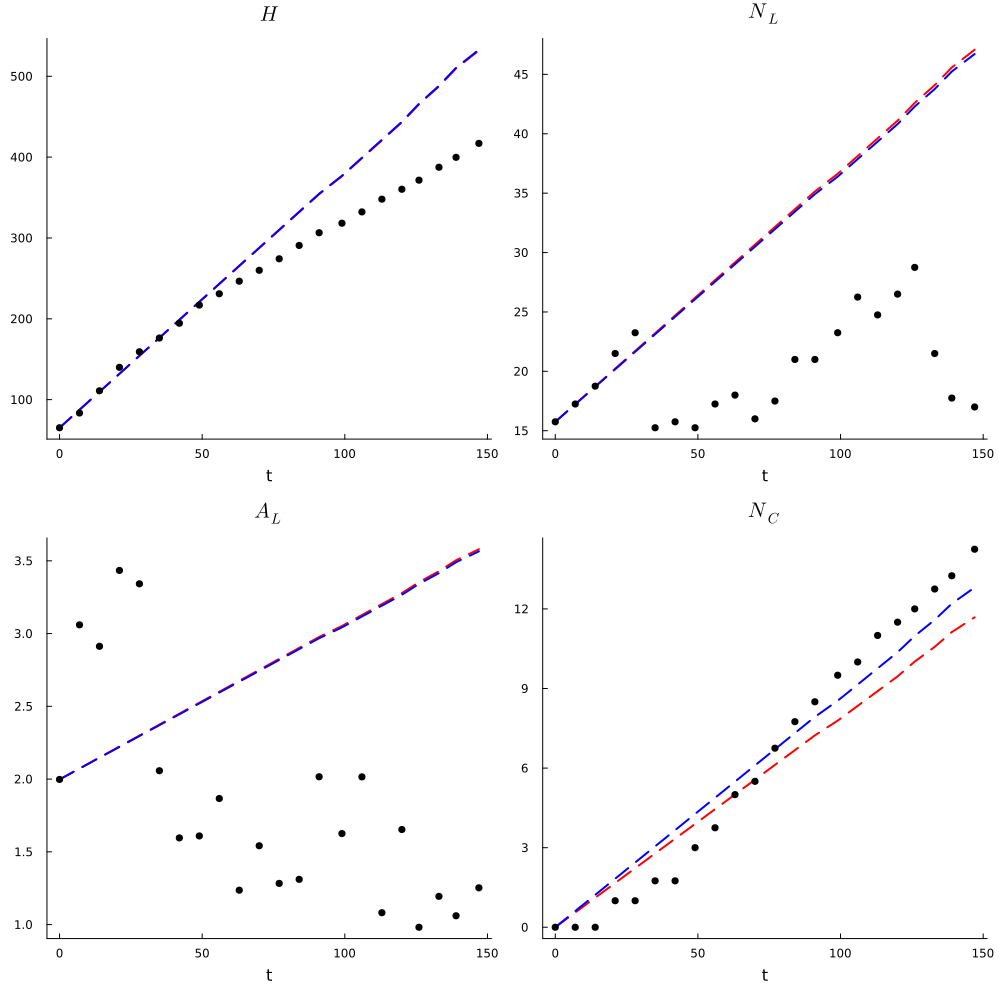

In [204]:
pdy1 = plot(Time,solve_system(MAP)[:,1],color=:red,label="",lw=2,linestyle=:dash,
    grid=false,xlabel="t",title=L"$H$")
pdy1 = plot!(Time,solve_system(CM)[:,1],color=:blue,label="",lw=2,linestyle=:dash)
pdy1 = scatter!(Time,Measurements[:,1],color=:black,label="",lw=2,linestyle=:dash)


pdy2 = plot(Time,solve_system(MAP)[:,2],color=:red,label="",lw=2,linestyle=:dash,
    grid=false,xlabel="t",title=L"$N_{L}$")
pdy2 = plot!(Time,solve_system(CM)[:,2],color=:blue,label="",lw=2,linestyle=:dash)
pdy2 = scatter!(Time,Measurements[:,2],color=:black,label="",lw=2,linestyle=:dash)


pdy3 = plot(Time,solve_system(MAP)[:,3],color=:red,label="",lw=2,linestyle=:dash,
    grid=false,xlabel="t",title=L"$A_{L}$")
pdy3 = plot!(Time,solve_system(CM)[:,3],color=:blue,label="",lw=2,linestyle=:dash)
pdy3 = scatter!(Time,Measurements[:,3],color=:black,label="",lw=2,linestyle=:dash)

pdy4 = plot(Time,solve_system(MAP)[:,4],color=:red,label="",lw=2,linestyle=:dash,
    grid=false,xlabel="t",title=L"$N_{C}$")
pdy4 = plot!(Time,solve_system(CM)[:,4],color=:blue,label="",lw=2,linestyle=:dash)
pdy4 = scatter!(Time,Measurements[:,4],color=:black,label="",lw=2,linestyle=:dash)


plot(pdy1,pdy2,pdy3,pdy4,layout=(2,2),size=(1000,1000))

#savefig("5_TOMGRO_PEinRD_Dynamics.png")